In [1]:
# Use the Azure Machine Learning data collector to log various metrics
from azureml.logging import get_azureml_logger
logger = get_azureml_logger()

In [2]:
! python --version

Python 3.5.2


In [3]:
# Use Azure Machine Learning history magic to control history collection
# History is off by default, options are "on", "off", or "show"
# %azureml history on

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os, time
from cvtk.core import Context, ObjectDetectionDataset, TFFasterRCNN
from cvtk.utils import detection_utils

# Disable printing of logging messages
from azuremltkbase.logging import ToolkitLogger
ToolkitLogger.getInstance().setEnabled(False)

# Initialize the context object
out_root_path = "../../../cvtk_output"
Context.create(outputs_path=out_root_path, persistent_path=out_root_path, temp_path=out_root_path)

from matplotlib import pyplot as plt
# Display the images
%matplotlib inline

F1 2018-08-08 03:51:52,787 INFO azureml.vision:machine info {"is_dsvm": true, "os_type": "Windows"} 
F1 2018-08-08 03:51:52,789 INFO azureml.vision:dataset creating dataset for scenario=detection 
Dataset name: training_dataset
Total classes: 3, total images: 242
Label-wise object counts:
	Label New: 113 objects
	Label Old: 75 objects
	Label Wrong: 72 objects
Bounding box width and height distribution:
	Bounding box widths  0/5/25/50/75/95/100-percentile: 16/30/98/230/293/518/757 pixels
	Bounding box heights 0/5/25/50/75/95/100-percentile: 18/32/56/67/96/181/340 pixels


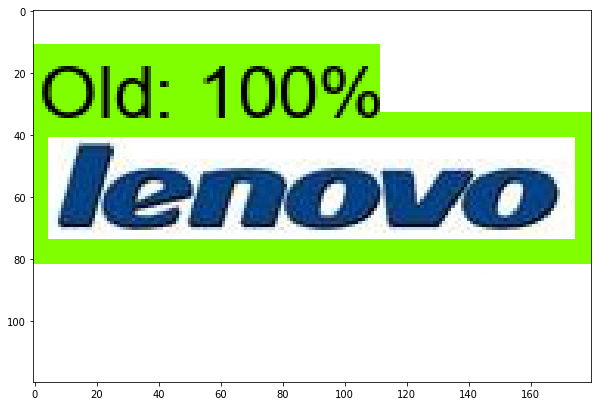

In [5]:
image_folder = "C:/Users/jxm/Downloads/cvp-1.0.0b3/cvp_project/detection/sample_data/labelling_output4/train"
data_train = ObjectDetectionDataset.create_from_dir(dataset_name='training_dataset', data_dir=image_folder,
                                                    annotations_dir="Annotations", image_subdirectory='JPEGImages')

# Show some statistics of the training image, and also give one example of the ground truth rectangle annotations
data_train.print_info()
_ = data_train.images[2].visualize_bounding_boxes(image_size = (10,10))

In [9]:
score_threshold = 0.0       # Threshold on the detection score, use to discard lower-confidence detections.
max_total_detections = 300  # Maximum number of detections. A high value will slow down training but might increase accuracy.
iou_threshold = 0.5
my_detector = TFFasterRCNN(labels=data_train.labels, 
                           score_threshold=score_threshold, 
                           max_total_detections=max_total_detections, iou_threshold=iou_threshold)

In [10]:
print("tensorboard --logdir={}".format(my_detector.train_dir))

# to get good results, use a larger value for num_steps, e.g., 5000.
num_steps = 5000
learning_rate = 0.001 # learning rate

start_train = time.time()
my_detector.train(dataset=data_train, num_steps=num_steps, 
                  initial_learning_rate=learning_rate)
end_train = time.time()
print(end_train-start_train)

tensorboard --logdir=C:\Users\jxm\cvtk_output\temp_faster_rcnn_resnet50\models\train
F1 2018-08-08 04:23:43,120 INFO azureml.vision:Fit starting in experiment  637865337 
F1 2018-08-08 04:23:43,122 INFO azureml.vision:model starting trainging for scenario=detection 
Using existing checkpoint file that's saved at 'C:\Users\jxm\cvtk_output\models\detection\faster_rcnn_resnet50_coco_2018_01_28\model.ckpt.index'.
TFRecords creation started.
F1 2018-08-08 04:23:43,126 INFO On image 0 of 242
F1 2018-08-08 04:23:43,224 INFO On image 100 of 242
F1 2018-08-08 04:23:43,348 INFO On image 200 of 242
TFRecords creation completed.
Training started.
Training progressing: step 0 ...
Training progressing: step 100 ...
Training progressing: step 200 ...
Training progressing: step 300 ...
Training progressing: step 400 ...
Training progressing: step 500 ...
Training progressing: step 600 ...
Training progressing: step 700 ...
Training progressing: step 800 ...
Training progressing: step 900 ...
Training 

In [11]:
image_folder = "C:/Users/jxm/Downloads/cvp-1.0.0b3/cvp_project/detection/sample_data/labelling_output4/val"
data_val = ObjectDetectionDataset.create_from_dir(dataset_name='val_dataset', data_dir=image_folder)
eval_result = my_detector.evaluate(dataset=data_val)

# print out the performance metric values
for label_obj in data_train.labels:
    label = label_obj.name
    key = 'PASCAL/PerformanceByCategory/AP@0.5IOU/' + label
    print('{0: <15}: {1: <3}'.format(label, round(eval_result[key], 2)))
    
print('{0: <15}: {1: <3}'.format("overall:", round(eval_result['PASCAL/Precision/mAP@0.5IOU'], 2))) 

F1 2018-08-08 05:57:19,308 INFO azureml.vision:dataset creating dataset for scenario=detection 
F1 2018-08-08 05:57:19,368 INFO On image 0 of 56
F1 2018-08-08 05:57:23,625 INFO Starting evaluation at 2018-08-08-05:57:23
F1 2018-08-08 05:57:25,964 INFO Creating detection visualizations.
F1 2018-08-08 05:57:26,100 INFO Detection visualizations written to summary with tag image-0.
F1 2018-08-08 05:57:26,463 INFO Creating detection visualizations.
F1 2018-08-08 05:57:26,557 INFO Detection visualizations written to summary with tag image-1.
F1 2018-08-08 05:57:26,894 INFO Creating detection visualizations.
F1 2018-08-08 05:57:26,992 INFO Detection visualizations written to summary with tag image-2.
F1 2018-08-08 05:57:27,326 INFO Creating detection visualizations.
F1 2018-08-08 05:57:27,427 INFO Detection visualizations written to summary with tag image-3.
F1 2018-08-08 05:57:27,756 INFO Creating detection visualizations.
F1 2018-08-08 05:57:27,852 INFO Detection visualizations written to s

In [12]:
print("tensorboard --logdir={} --port=8008".format(my_detector.eval_dir))

tensorboard --logdir=C:\Users\jxm\cvtk_output\temp_faster_rcnn_resnet50\models\eval --port=8008


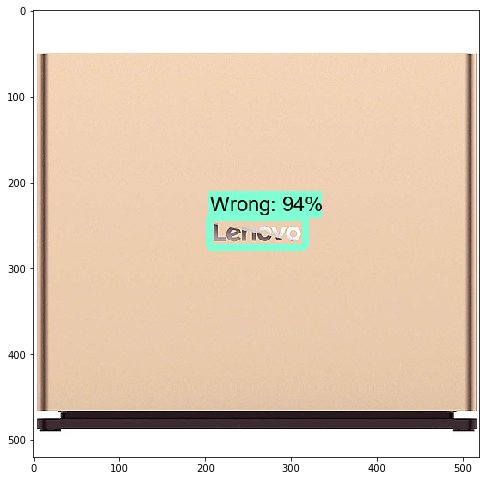

In [36]:
image_path = "C:/Users/jxm/Downloads/cvp-1.0.0b3/cvp_project/detection/sample_data/labelling_output3/JPEGImages/w31.jpg"
scores = my_detector.score(image_path)
path_save = "C:/Users/jxm/Downloads/cvp-1.0.0b3/cvp_project/detection/sample_data/labelling_output3/test/result.jpg"
ax = detection_utils.visualize(image_path, scores, image_size=(8, 12))
path_save_dir = os.path.dirname(os.path.abspath(path_save))
os.makedirs(path_save_dir, exist_ok=True)
ax.get_figure().savefig(path_save)

In [25]:
#save_model_path = out_root_path + "/frozen_model/faster_rcnn_lenovo.model" # Please save your model to outside of your AML workbench project folder because of the size limit of AML project
#my_detector.save(save_model_path)

F1 2018-08-08 06:09:39,096 INFO Graph Rewriter optimizations enabled
Converted 275 variables to const ops.
F1 2018-08-08 06:09:47,527 INFO 2438 ops in the final graph.


In [34]:
my_detector_loaded = TFFasterRCNN.load(save_model_path)
detections_dict = my_detector_loaded.score(image_path)
look_up = dict((v,k) for k,v in my_detector.class_map.items())
n_obj = 0
for i in range(detections_dict['num_detections']):
    if detections_dict['detection_scores'][i] > 0.5:
        n_obj += 1
        print("Object {}: label={:11}, score={:.2f}, location=(top: {:.2f}, left: {:.2f}, bottom: {:.2f}, right: {:.2f})".format(
            i, look_up[detections_dict['detection_classes'][i]], 
            detections_dict['detection_scores'][i], 
            detections_dict['detection_boxes'][i][0],
            detections_dict['detection_boxes'][i][1], 
            detections_dict['detection_boxes'][i][2],
            detections_dict['detection_boxes'][i][3]))    
        
print("\nFound {} objects in image {}.".format(n_obj, image_path))           

Object 0: label=New        , score=0.51, location=(top: 0.00, left: 0.18, bottom: 1.00, right: 0.44)

Found 1 objects in image C:/Users/jxm/Downloads/cvp-1.0.0b3/cvp_project/detection/sample_data/labelling_output3/JPEGImages/n18.jpg.


In [ ]:
#path_save = out_root_path + "/scored_images/scored_image_frozen_graph.jpg"
#ax = detection_utils.visualize(image_path, detections_dict, path_save=path_save, image_size=(8, 12))
# ax.get_figure() # use this code extract the returned image